## SIFT + Bag of Visual Words

Sacado de https://github.com/gurkandemir/Bag-of-Visual-Words/blob/master/Code%20Files/BoW.py

In [2]:
from funciones import *

In [6]:
nombre_csv="gatos.csv"
#make_dataset(dir_imagenes, nombre_csv)

df = pd.read_csv(nombre_csv)
# df=df[df['Family'] == 'Gato']
images_train, images_test, classes_train, classes_test=split_train_test(df, 0.9)
classes=get_classes(df)
# no_clusters=500
# kernel="precomputed"
# labels="/home/sere/Escritorio/trabajotimag/annotations/trimaps"
# execute(images_train, images_test, classes_train, classes_test, no_clusters, kernel, classes)
#test(images_test, classes_test, no_clusters, kernel, classes)

In [7]:
# busqueda de hiperparametros:
for no_clusters in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    for kernel in ["precomputed", "linear", "poly", "rbf", "sigmoid"]:
        print("No clusters: ", no_clusters, " Kernel: ", kernel)
        labels="/home/sere/Escritorio/trabajotimag/annotations/trimaps"
        execute(images_train, images_test, classes_train, classes_test, no_clusters, kernel, classes)

No clusters:  100  Kernel:  precomputed
Descriptors loaded.


{'0': 'Bombay', '1': 'Abyssinian', '2': 'Russian_Blue', '3': 'Bengal', '4': 'Persian', '5': 'Maine_Coon', '6': 'Siamese', '7': 'British_Shorthair', '8': 'Ragdoll', '9': 'Sphynx', '10': 'Birman', '11': 'Egyptian_Mau'}


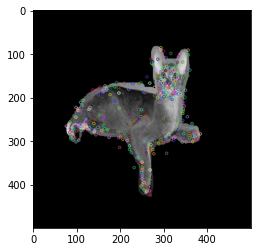

Test images classified.
['Sphynx']


In [7]:
no_clusters=500
kernel="precomputed"s
inferencia_eval("/home/sere/Escritorio/trabajotimag/images/Abyssinian_1.jpg", "/home/sere/Escritorio/trabajotimag/annotations/trimaps", no_clusters, kernel, classes)